# Verbesserung des Überlapptrackings

Das Objekttracking ist derzeit leider immernoch zu instabil. Deshalb sehen wir uns den Ansatz hier nochmal an.

In [83]:
import sys
import numpy as np
import pandas as pd
import xarray as xr

import glob
import matplotlib.pyplot as plt
%matplotlib inline

from plotting_tools.colormaps import enhanced_colormap
emap = enhanced_colormap()

sys.path.append("/vols/talos/home/stephan/utils/tracking/")
import object_tracking as ot
import tracking_common as tc

from scipy import ndimage as ndi
import fixed_colourbar as fc
import operator

In [78]:
talos_home = "/vols/talos/home/stephan"
data_path = "{talos_home}/data".format(talos_home=talos_home)
#track_data_path = "{dp}/radar_track/trackdata".format(dp=data_path)
track_data_path = "{dp}/radar_track/trackdata/hires/".format(dp=data_path)

Dann laden wir uns doch mal ein Beispiel.

In [79]:
track_paths = glob.glob("{tdp}/*.nc".format(tdp=track_data_path))

In [80]:
track_example = xr.open_dataset(track_paths[1]) 

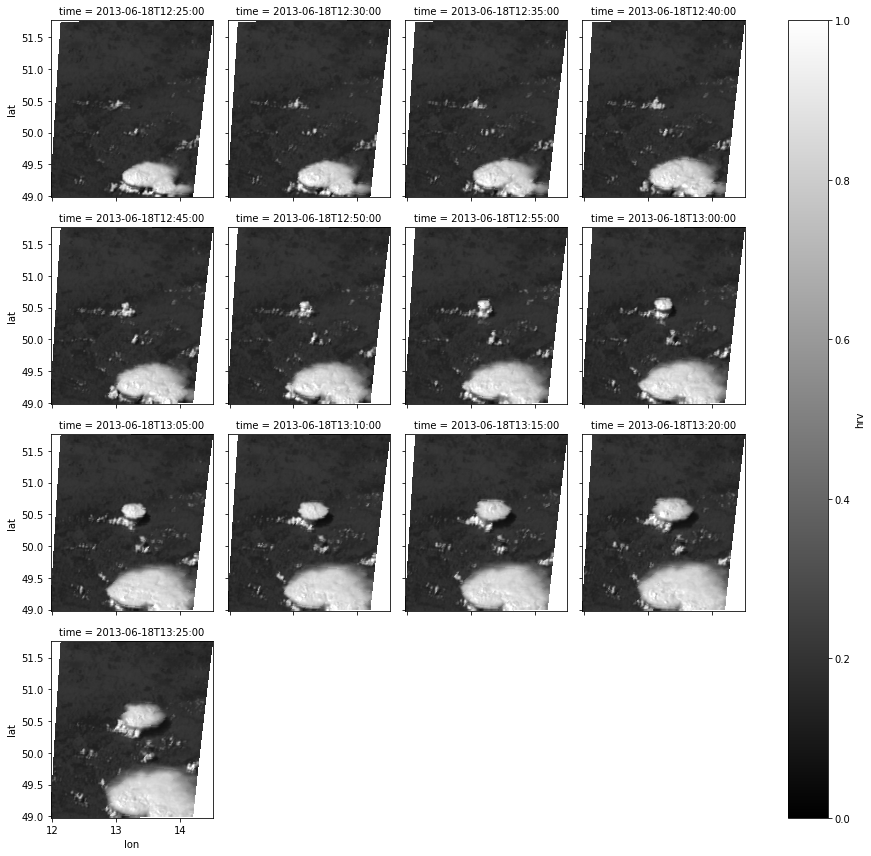

In [81]:
track_example.hrv.plot(x='lon',y='lat',col='time',col_wrap=4,cmap='gray',vmin=0,vmax=1)

## Objekte finden mit Nächster-Nachbar-Markierung

Als einfachen Ansatz wenden wir einen Schwellwert an und verbinden die Objekte.

In [7]:
hrv_smoothed = ndi.gaussian_filter(track_example.hrv,0)

In [8]:
#hrv_thresholded = track_example.hrv.where(track_example.hrv > 0.3)
hrv_thresholded = np.ma.masked_less(hrv_smoothed,0.3)

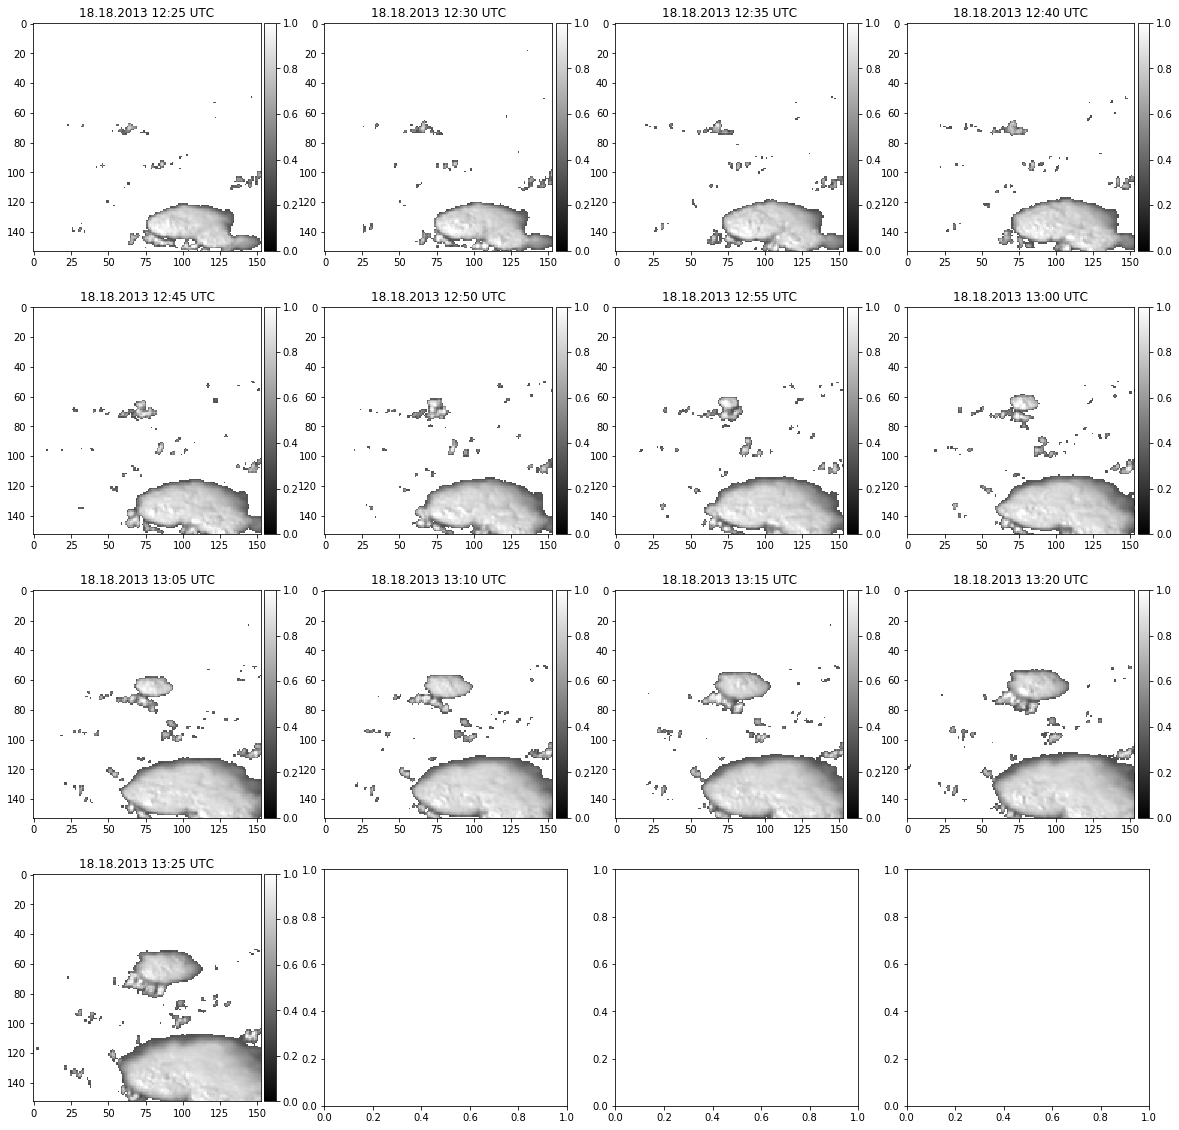

In [9]:
#hrv_thresholded.plot(x='lon',y='lat',col='time',col_wrap=4,cmap='gray',vmin=0,vmax=1)
fig,ax = plt.subplots(4,4,figsize=(20,20))
axs= ax.ravel()

for i,h in enumerate(hrv_thresholded):
    plot = axs[i].imshow(h,vmin=0,vmax=1,cmap='gray')
    axs[i].set_title(pd.Timestamp(track_example.time.data[i]).strftime("%d.%d.%Y %H:%M UTC"))
    fc.colourbar(plot)

In [10]:
#hrv_segmented = ~np.ma.masked_invalid(hrv_thresholded.data).mask*1
hrv_segmented = ~np.ma.masked_invalid(hrv_thresholded.mask)*1

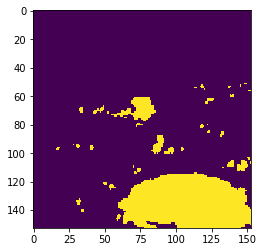

In [11]:
plt.imshow(hrv_segmented[6])

Um das Objekttrackign etwas stabiler zu bekommen, ist es vielleicht eine gute Idee die Objekte etwas zu dilatatieren.

In [12]:
selem = np.ones((3,3))

In [13]:
hrv_segmented_dil = ndi.morphology.binary_dilation(hrv_segmented)

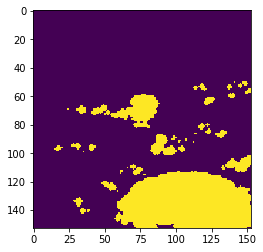

In [14]:
plt.imshow(hrv_segmented_dil[6])

Damit können wir die Überlappungen bestimmen.

In [15]:
overlaps = dict()

for i,h in enumerate(hrv_segmented_dil):
    if i <=11:
        ol = h & hrv_segmented_dil[i+1]
    
        overlaps['{}->{}'.format(i,i+1)] = ol
    else:
        continue

In [16]:
hrv_labeled = []
labels = []

for h in hrv_segmented:
    hl,l = ndi.label(h)
    hrv_labeled.append(hl)
    labels.append(l)

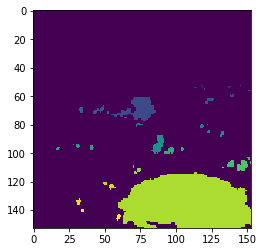

In [17]:
plt.imshow(hrv_labeled[6])

In [18]:
hrv_labeled_dil = np.array([ndi.morphology.grey_dilation(hl,size=(3,3)) for hl in hrv_labeled])

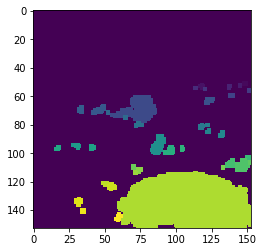

In [19]:
plt.imshow(hrv_labeled_dil[6])

Text(0.5,1,u'\xfcberlappende Objekte')

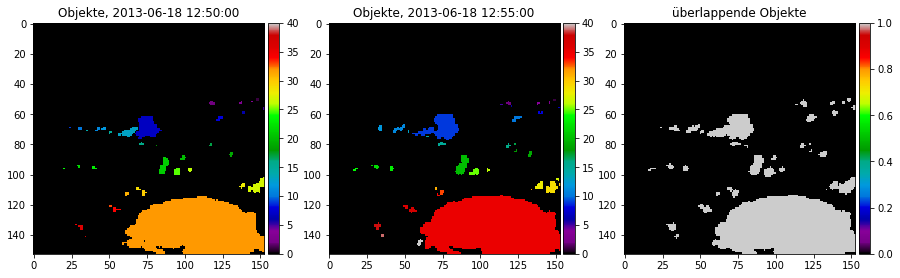

In [20]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
plot0 = ax[0].imshow(hrv_labeled[5],vmin=0,vmax=np.max(labels[6]),cmap='nipy_spectral')
fc.colourbar(plot0)
ax[0].set_title("Objekte, {}".format(pd.Timestamp(track_example.time[5].data)))

plot1 = ax[1].imshow(hrv_labeled[6],vmin=0,vmax=np.max(labels[6]),cmap='nipy_spectral')
fc.colourbar(plot1)
ax[1].set_title("Objekte, {}".format(pd.Timestamp(track_example.time[6].data)))

plot2 = ax[2].imshow(overlaps['5->6'], vmin=0,vmax=1,cmap='nipy_spectral')
fc.colourbar(plot2)
ax[2].set_title(u"überlappende Objekte")

Das funktioniert soweit. Dann können wir darauf die Routinen der Objektwerkzeuge anwenden.

In [21]:
connections = ot.generate_graph_from_components(np.array(hrv_labeled_dil),np.arange(0,13))

In [22]:
oid = ot.get_wanted_object_id(hrv_labeled_dil)
print oid

9


In [23]:
object_graph = ot.get_wanted_graph(connections[1],"6_{:04d}".format(oid))

In [24]:
wanted_graph = ot.sort_graph_by_timesteps(object_graph)

In [25]:
wanted_graph

{0: ['0_0009', '0_0008', '0_0004', '0_0007', '0_0006'],
 1: ['1_0008', '1_0006', '1_0004', '1_0005'],
 2: ['2_0006', '2_0005', '2_0010', '2_0011'],
 3: ['3_0007', '3_0009', '3_0006', '3_0013', '3_0012'],
 4: ['4_0010', '4_0006', '4_0009', '4_0008'],
 5: ['5_0015', '5_0016', '5_0011', '5_0013', '5_0012', '5_0007'],
 6: ['6_0014', '6_0011', '6_0013', '6_0009', '6_0015'],
 7: ['7_0009', '7_0006'],
 8: ['8_0007', '8_0012', '8_0011'],
 9: ['9_0006', '9_0004', '9_0008'],
 10: ['10_0010', '10_0011', '10_0005'],
 11: ['11_0008', '11_0003'],
 12: ['12_0009', '12_0008', '12_0002']}

In [26]:
main_track = ot.get_main_track(hrv_labeled_dil,wanted_graph,"6_000{}".format(oid))

In [27]:
mt = []

for tp in main_track:
    t_idx = int(tp.split("_")[0])
    oid = int(tp.split("_")[1])
    
    cut = np.zeros_like(hrv_labeled_dil[6])
    
    obj_locations = np.where(hrv_labeled[t_idx] == oid)
    
    cut[obj_locations] = oid
    mt.append(cut)

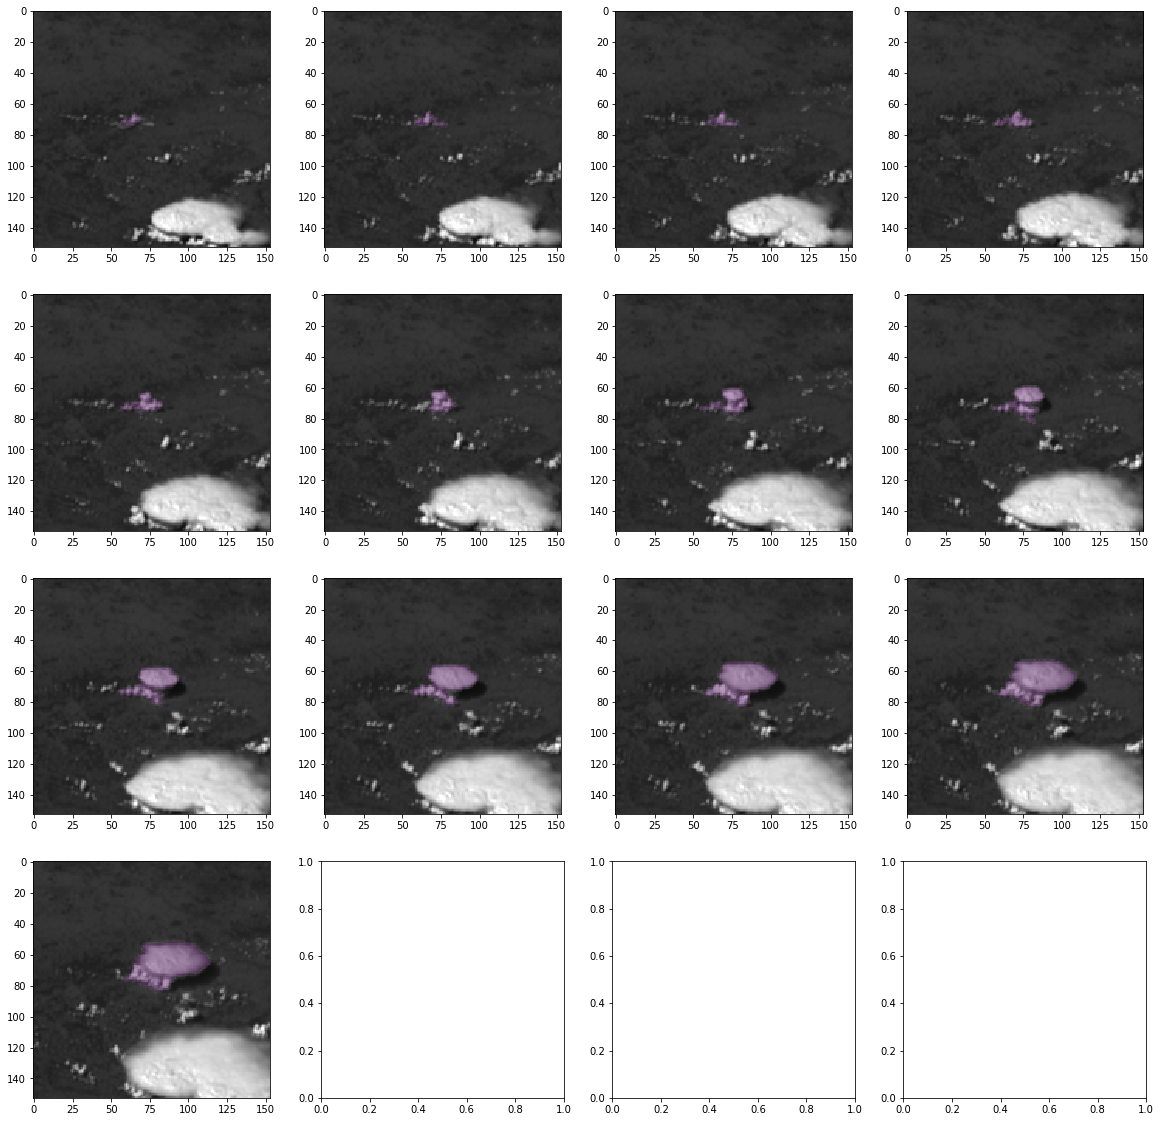

In [28]:
fig,ax = plt.subplots(4,4,figsize=(20,20))
axs = ax.ravel()

for i, c in enumerate(mt):
    axs[i].imshow(track_example.hrv.data[i],vmin=0,vmax=1,cmap='gray')
    axs[i].imshow(np.ma.masked_less(c,1),alpha=0.4)

In [29]:
import operator

In [34]:
seg_hrv = ot.segmentation_dilation(track_example.hrv.data,0.3,1)

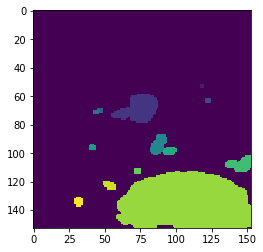

In [35]:
plt.imshow(seg_hrv[6])

In [36]:
seg_ir108 = ot.segmentation_dilation(track_example.ir108.data,260,0,3,operator.lt)

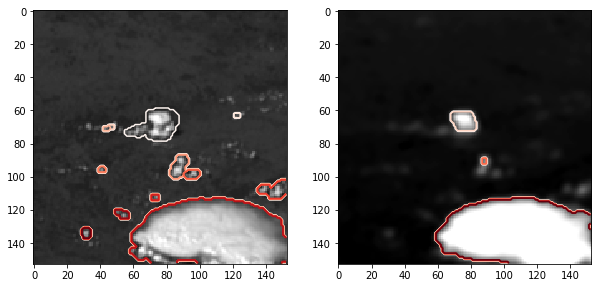

In [37]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(track_example.hrv.data[6],vmin=0,vmax=1,cmap='gray')
ax[0].contour(seg_hrv[6], levels=np.arange(1,np.max(seg_hrv[6])+1),cmap='Reds')
ax[1].imshow(track_example.ir108.data[6],vmin=220,vmax=300,cmap='gray_r')
ax[1].contour(seg_ir108[6],cmap='Reds')

In [38]:
main_track_hrv = ot.get_track_from_labeled_field(seg_hrv)

In [39]:
main_track_ir108 = ot.get_track_from_labeled_field(seg_ir108)

In [40]:
mt_hrv = dict()

for i, obj in enumerate(main_track_hrv):
    t_idx = int(obj.split("_")[0])
    oid = int(obj.split("_")[1])
    
    cut = np.zeros_like(seg_hrv[i])
    
    obj_locations = np.where(seg_hrv[t_idx] == oid)
    
    cut[obj_locations] = 1
    mt_hrv[t_idx] = cut

mt_ir108 = dict()

for i, obj in enumerate(main_track_ir108):
    t_idx = int(main_track_ir108[i].split("_")[0])
    oid = int(main_track_ir108[i].split("_")[1])

    cut = np.zeros_like(seg_ir108[i])

    obj_locations = np.where(seg_ir108[t_idx] == oid)

    cut[obj_locations] = 1
    mt_ir108[t_idx] = cut

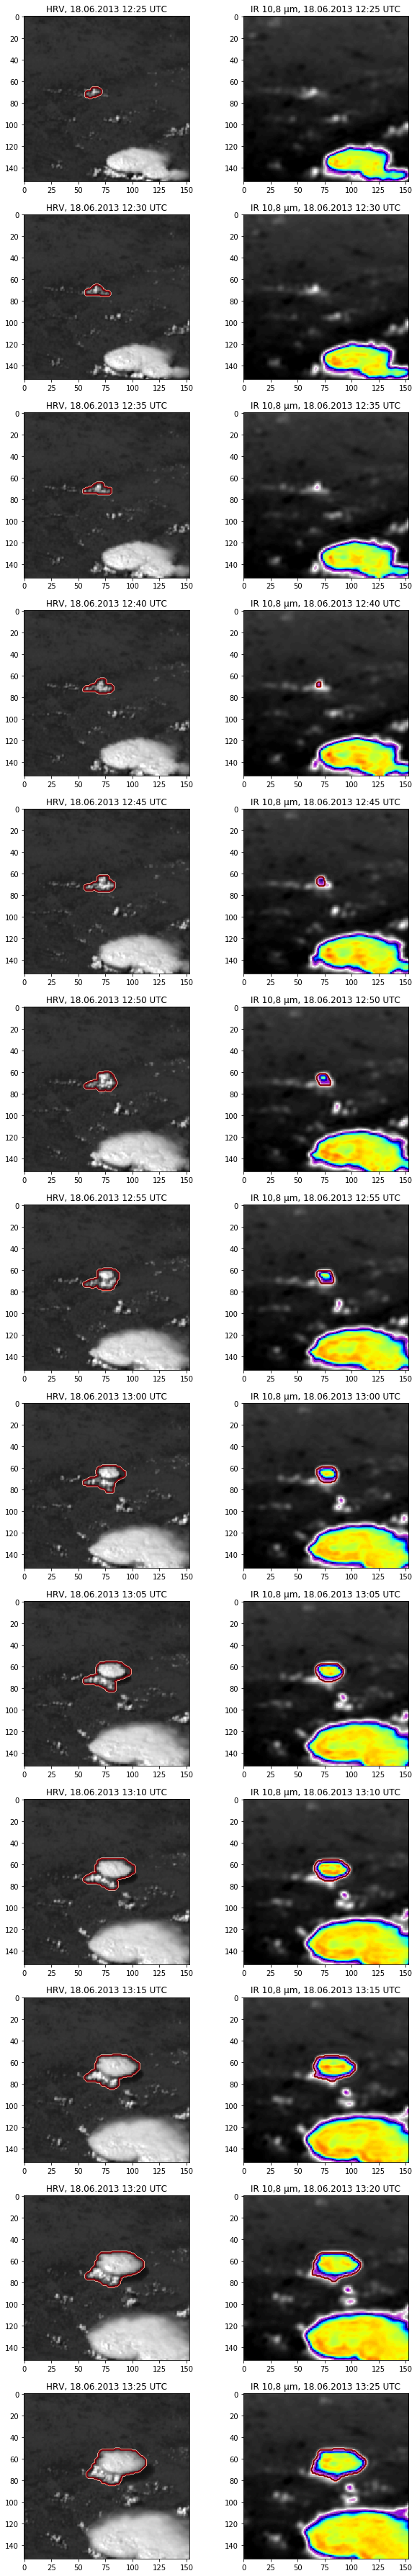

In [42]:
fig,ax = plt.subplots(13,2,figsize=(10,13*5))
for i, h in enumerate(mt_hrv):
    ax[i,0].imshow(track_example.hrv.data[i],vmin=0,vmax=1,cmap='gray')
    ax[i,0].contour(mt_hrv[h],cmap='Reds')
    ax[i,0].set_title("HRV, {}".format(pd.Timestamp(track_example.time.data[i]).strftime("%d.%m.%Y %H:%M UTC")))
    try:
        ax[i,1].imshow(track_example.ir108.data[i],vmin=200,vmax=300,cmap=emap)
        ax[i,1].contour(mt_ir108[i],cmap='Reds')
    except:
        ax[i,1].imshow(track_example.ir108.data[i],vmin=200,vmax=300,cmap=emap)
    ax[i,1].set_title(u"IR 10,8 µm, {}".format(pd.Timestamp(track_example.time.data[i]).strftime("%d.%m.%Y %H:%M UTC")))


## Objekteigenschaften

Das sieht doch ganz gut aus. Dann sehen wir uns doch mal die Objekteigenschaften an.

In [62]:
hrv_properties = {'min':[],'max':[],'med':[],'mean':[],'q25':[],'q75':[],'values':[]}
ir108_properties = {'min':[],'max':[],'med':[],'mean':[],'q25':[],'q75':[],'values':[]}

In [63]:
tid = np.arange(0,13)

In [64]:
for t in tid:
    try:
        obj_idx = np.where(mt_hrv[t]!=0)

        obj_values = track_example.hrv.data[t][obj_idx]

        hrv_properties['min'].append(np.min(obj_values))
        hrv_properties['max'].append(np.max(obj_values))
        hrv_properties['med'].append(np.median(obj_values))
        hrv_properties['mean'].append(np.mean(obj_values))
        hrv_properties['q25'].append(np.percentile(obj_values,25))
        hrv_properties['q75'].append(np.percentile(obj_values,75))
        hrv_properties['values'].append(obj_values)
    except:
        hrv_properties['min'].append(np.nan)
        hrv_properties['max'].append(np.nan)
        hrv_properties['med'].append(np.nan)
        hrv_properties['mean'].append(np.nan)
        hrv_properties['q25'].append(np.nan)
        hrv_properties['q75'].append(np.nan)
        hrv_properties['values'].append(np.nan)

In [65]:
for t in tid:
    try:
        obj_idx = np.where(mt_ir108[t]!=0)

        obj_values = track_example.ir108.data[t][obj_idx]

        ir108_properties['min'].append(np.min(obj_values))
        ir108_properties['max'].append(np.max(obj_values))
        ir108_properties['med'].append(np.median(obj_values))
        ir108_properties['mean'].append(np.mean(obj_values))
        ir108_properties['q25'].append(np.percentile(obj_values,25))
        ir108_properties['q75'].append(np.percentile(obj_values,75))
        ir108_properties['values'].append(obj_values)
    except:
        ir108_properties['min'].append(np.nan)
        ir108_properties['max'].append(np.nan)
        ir108_properties['med'].append(np.nan)
        ir108_properties['mean'].append(np.nan)
        ir108_properties['q25'].append(np.nan)
        ir108_properties['q75'].append(np.nan)
        ir108_properties['values'].append(np.nan)

In [59]:
time = [pd.Timestamp(t) for t in track_example.time.data]

In [60]:
tidx = np.arange(-30,35,5)

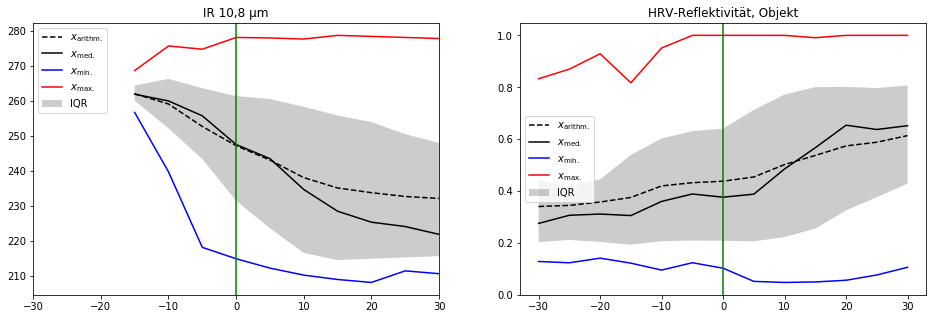

In [66]:
fig,ax = plt.subplots(1,2,figsize=(16,5))
ax[0].plot(tidx,ir108_properties['mean'],'k--',label=r'$x_\mathrm{arithm.}$')
ax[0].plot(tidx,ir108_properties['med'],'k-',label=r'$x_\mathrm{med.}$')
ax[0].plot(tidx,ir108_properties['min'],'b-',label=r'$x_\mathrm{min.}$')
ax[0].plot(tidx,ir108_properties['max'],'r-',label=r'$x_\mathrm{max.}$')
ax[0].fill_between(tidx, ir108_properties['q25'], ir108_properties['q75'],
                 facecolor='gray', interpolate=True,alpha=0.4, label='IQR')
ax[0].set_title(u"IR 10,8 µm")
ax[0].axvline(0, color='green')
ax[0].legend()
ax[0].set_xlim(-30,30)

ax[1].plot(tidx,hrv_properties['mean'],'k--',label=r'$x_\mathrm{arithm.}$')
ax[1].plot(tidx,hrv_properties['med'],'k-',label=r'$x_\mathrm{med.}$')
ax[1].plot(tidx,hrv_properties['min'],'b-',label=r'$x_\mathrm{min.}$')
ax[1].plot(tidx,hrv_properties['max'],'r-',label=r'$x_\mathrm{max.}$')
ax[1].fill_between(tidx, hrv_properties['q25'], hrv_properties['q75'],
                 facecolor='gray', interpolate=True,alpha=0.4, label='IQR')
ax[1].set_title(u"HRV-Reflektivität, Objekt")
ax[1].axvline(0, color='green')
ax[1].legend()

In [67]:
import seaborn as sns

In [68]:
val = []
time = []
field = []

for i,v in enumerate(hrv_properties['values']):
    val.extend(v)
    time.extend([tidx[i]]*len(v))
    field.extend(['HRV'] * len(v))

for i,v in enumerate(ir108_properties['values']):
    try:
        val.extend(v)
        time.extend([tidx[i]]*len(v))
        field.extend([u'IR 10,8 µm'] * len(v))
    except:
        continue

In [69]:
dataset = pd.DataFrame({'value':val,'time':time,'field':field})

In [70]:
hrv_data = dataset[dataset.field=='HRV']
ir108_data = dataset[dataset.field==u'IR 10,8 µm']

(0, 1)

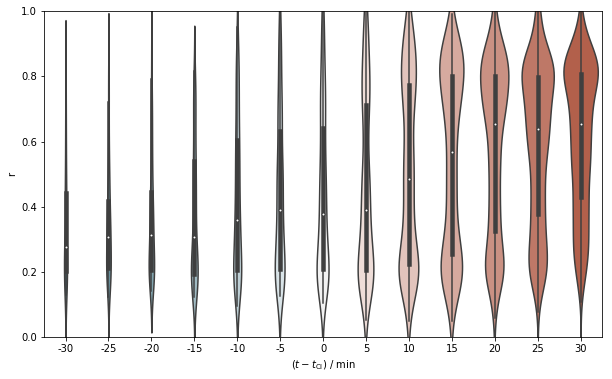

In [75]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax = sns.violinplot(x='time',y='value',
                    data=hrv_data,
                    palette=sns.color_palette(sns.diverging_palette(220, 20, n=13)),
                    scale='count')
ax.set_ylabel(u"r")
ax.set_xlabel(r"$(t - t_\mathrm{CI})$ / min")
ax.set_ylim((0,1))

Text(0.5,0,'$(t - t_\\mathrm{CI})$ / min')

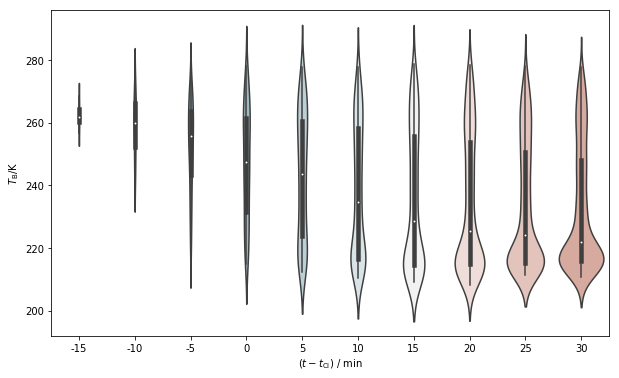

In [74]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax = sns.violinplot(x='time',y='value',
                    data=ir108_data,
                    palette=sns.color_palette(sns.color_palette(sns.diverging_palette(220, 20, n=13))),
                    scale='count')
ax.set_ylabel(r"$T_\mathrm{B} / \mathrm{K}$")
ax.set_xlabel(r"$(t - t_\mathrm{CI})$ / min")

In [76]:
tid = np.arange(0,13)
tidx = np.arange(-30,35,5)

In [77]:
path = "/vols/talos/home/stephan/proj/2019-01_trackingstudie/pics/objects/"

In [8]:
tr = track_paths[0]

In [9]:
track_data = xr.open_dataset(tr)

In [47]:
seg_hrv = ot.segmentation_dilation(track_data.hrv.data,0.3,1)
seg_ir108 = ot.segmentation_dilation(track_data.ir108.data,260,0,3,operator.lt)

main_track_hrv = ot.get_track_from_labeled_field(seg_hrv)
main_track_ir108 = ot.get_track_from_labeled_field(seg_ir108)

In [48]:
mt_hrv = dict()

for i, obj in enumerate(main_track_hrv):
    t_idx = int(obj.split("_")[0])
    oid = int(obj.split("_")[1])

    cut = np.zeros_like(seg_hrv[i])

    obj_locations = np.where(seg_hrv[t_idx] == oid)

    cut[obj_locations] = 1
    mt_hrv[t_idx] = cut

mt_ir108 = dict()

for i, obj in enumerate(main_track_ir108):
    t_idx = int(main_track_ir108[i].split("_")[0])
    oid = int(main_track_ir108[i].split("_")[1])

    cut = np.zeros_like(seg_ir108[i])

    obj_locations = np.where(seg_ir108[t_idx] == oid)

    cut[obj_locations] = 1
    mt_ir108[t_idx] = cut

In [54]:
tid

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [57]:
hrv_properties = {'min':[],'max':[],'med':[],'mean':[],'q25':[],'q75':[]}
ir108_properties = {'min':[],'max':[],'med':[],'mean':[],'q25':[],'q75':[]}

for t in tid:
    try:
        obj_idx = np.where(mt_hrv[t]!=0)

        obj_values = track_data.hrv.data[t][obj_idx]

        hrv_properties['min'].append(np.min(obj_values))
        hrv_properties['max'].append(np.max(obj_values))
        hrv_properties['med'].append(np.median(obj_values))
        hrv_properties['mean'].append(np.mean(obj_values))
        hrv_properties['q25'].append(np.percentile(obj_values,25))
        hrv_properties['q75'].append(np.percentile(obj_values,75))
    except:
        hrv_properties['min'].append(np.nan)
        hrv_properties['max'].append(np.nan)
        hrv_properties['med'].append(np.nan)
        hrv_properties['mean'].append(np.nan)
        hrv_properties['q25'].append(np.nan)
        hrv_properties['q75'].append(np.nan)

for t in tid:
    try:
        obj_idx = np.where(mt_ir108[t]!=0)

        obj_values = track_data.ir108.data[t][obj_idx]

        ir108_properties['min'].append(np.min(obj_values))
        ir108_properties['max'].append(np.max(obj_values))
        ir108_properties['med'].append(np.median(obj_values))
        ir108_properties['mean'].append(np.mean(obj_values))
        ir108_properties['q25'].append(np.percentile(obj_values,25))
        ir108_properties['q75'].append(np.percentile(obj_values,75))
    except:
        ir108_properties['min'].append(np.nan)
        ir108_properties['max'].append(np.nan)
        ir108_properties['med'].append(np.nan)
        ir108_properties['mean'].append(np.nan)
        ir108_properties['q25'].append(np.nan)
        ir108_properties['q75'].append(np.nan)

In [59]:
mt_hrv

{0: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 1: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 2: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 3: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 4: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 

(-30, 30)

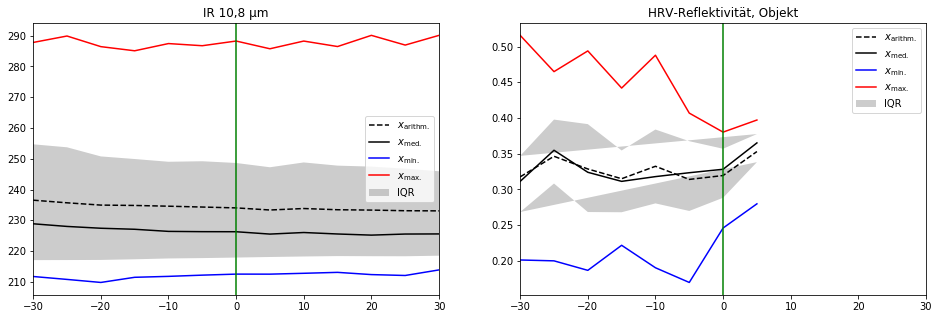

In [60]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(tidx,ir108_properties['mean'],'k--',label=r'$x_\mathrm{arithm.}$')
ax[0].plot(tidx,ir108_properties['med'],'k-',label=r'$x_\mathrm{med.}$')
ax[0].plot(tidx,ir108_properties['min'],'b-',label=r'$x_\mathrm{min.}$')
ax[0].plot(tidx,ir108_properties['max'],'r-',label=r'$x_\mathrm{max.}$')
ax[0].fill_between(tidx, ir108_properties['q25'], ir108_properties['q75'],
             facecolor='gray', interpolate=True,alpha=0.4, label='IQR')
ax[0].set_title(u"IR 10,8 µm")
ax[0].axvline(0, color='green')
ax[0].legend()
ax[0].set_xlim(-30,30)


ax[1].plot(tidx,hrv_properties['mean'],'k--',label=r'$x_\mathrm{arithm.}$')
ax[1].plot(tidx,hrv_properties['med'],'k-',label=r'$x_\mathrm{med.}$')
ax[1].plot(tidx,hrv_properties['min'],'b-',label=r'$x_\mathrm{min.}$')
ax[1].plot(tidx,hrv_properties['max'],'r-',label=r'$x_\mathrm{max.}$')
ax[1].fill_between(tidx, hrv_properties['q25'], hrv_properties['q75'],
             facecolor='gray', interpolate=True,alpha=0.4, label='IQR')
ax[1].set_title(u"HRV-Reflektivität, Objekt")
ax[1].axvline(0, color='green')
ax[1].legend()
ax[1].set_xlim(-30,30)

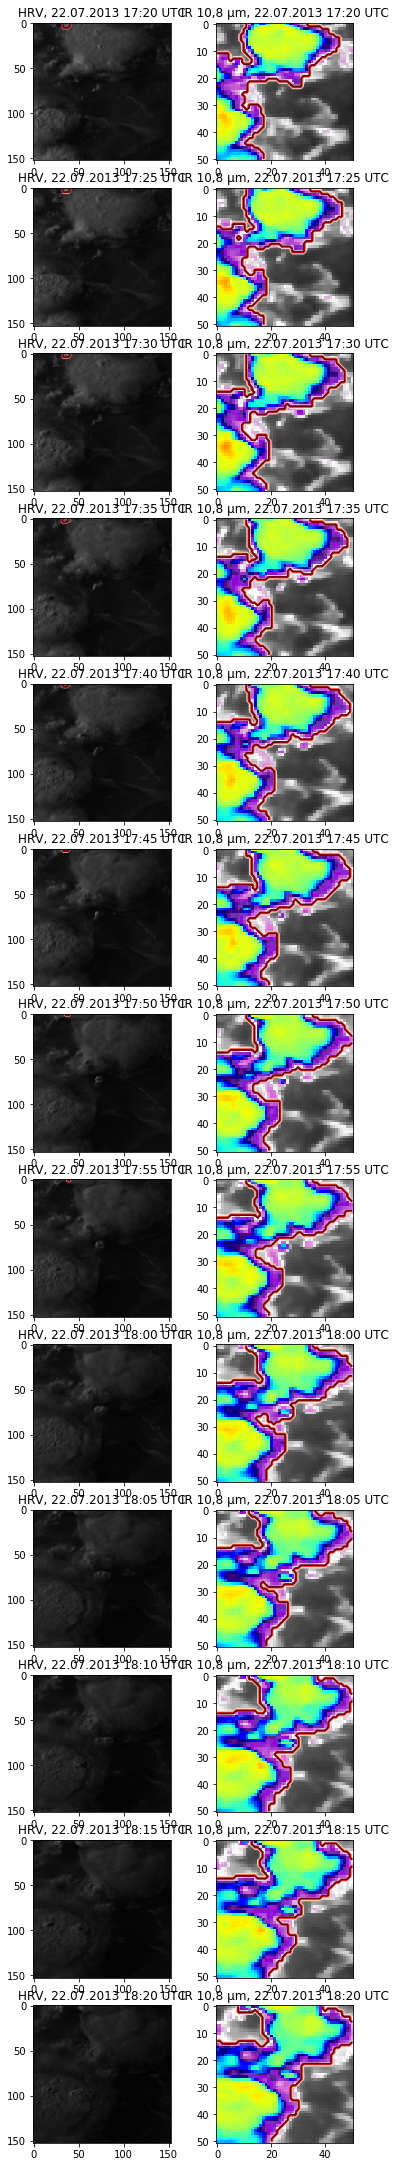

In [64]:
fig,ax = plt.subplots(13,2,figsize=(6,13*3))
for t in tid:
    ax[t,0].imshow(track_data.hrv.data[t],vmin=0,vmax=1,cmap='gray')
    try:
        ax[t,0].contour(mt_hrv[t],cmap='Reds')
        ax[t,0].imshow(track_data.hrv.data[t],vmin=0,vmax=1,cmap='gray')
    except:
        ax[t,0].imshow(track_data.hrv.data[t],vmin=0,vmax=1,cmap='gray')
    ax[t,0].set_title("HRV, {}".format(pd.Timestamp(track_data.time.data[t]).strftime("%d.%m.%Y %H:%M UTC")))

    try:
        ax[t,1].contour(mt_ir108[t],cmap='Reds')
        ax[t,1].imshow(track_data.ir108.data[t],vmin=200,vmax=300,cmap=emap)
    except:
        ax[t,1].imshow(track_data.ir108.data[t],vmin=200,vmax=300,cmap=emap)
    ax[t,1].set_title(u"IR 10,8 µm, {}".format(pd.Timestamp(track_data.time.data[t]).strftime("%d.%m.%Y %H:%M UTC")))
    #plt.tight_layout()
    #plt.savefig("{}/{}_verlauf.png".format(path,tr.split("/")[-1].split(".")[0]))
    #plt.close("all")

In [212]:
for tr in track_paths:
    try:
        track_data = xr.open_dataset(tr)
        seg_hrv = ot.segmentation_dilation(track_data.hrv.data,0.4,1)
        seg_ir108 = ot.segmentation_dilation(track_data.ir108.data,260,0,3,operator.lt)

        main_track_hrv = ot.get_track_from_labeled_field(seg_hrv)
        main_track_ir108 = ot.get_track_from_labeled_field(seg_ir108)

        mt_hrv = dict()

        for i, obj in enumerate(main_track_hrv):
            t_idx = int(obj.split("_")[0])
            oid = int(obj.split("_")[1])

            cut = np.zeros_like(seg_hrv[i])

            obj_locations = np.where(seg_hrv[t_idx] == oid)

            cut[obj_locations] = 1
            mt_hrv[t_idx] = cut

        mt_ir108 = dict()

        for i, obj in enumerate(main_track_ir108):
            t_idx = int(main_track_ir108[i].split("_")[0])
            oid = int(main_track_ir108[i].split("_")[1])

            cut = np.zeros_like(seg_ir108[i])

            obj_locations = np.where(seg_ir108[t_idx] == oid)

            cut[obj_locations] = 1
            mt_ir108[t_idx] = cut

        hrv_properties = {'min':[],'max':[],'med':[],'mean':[],'q25':[],'q75':[],'values':[]}
        ir108_properties = {'min':[],'max':[],'med':[],'mean':[],'q25':[],'q75':[],'values':[]}

        for t in tid:
            try:
                obj_idx = np.where(mt_hrv[t]!=0)

                obj_values = track_data.hrv.data[t][obj_idx]

                hrv_properties['min'].append(np.min(obj_values))
                hrv_properties['max'].append(np.max(obj_values))
                hrv_properties['med'].append(np.median(obj_values))
                hrv_properties['mean'].append(np.mean(obj_values))
                hrv_properties['q25'].append(np.percentile(obj_values,25))
                hrv_properties['q75'].append(np.percentile(obj_values,75))
                hrv_properties['values'].append(obj_values)
            except:
                hrv_properties['min'].append(np.nan)
                hrv_properties['max'].append(np.nan)
                hrv_properties['med'].append(np.nan)
                hrv_properties['mean'].append(np.nan)
                hrv_properties['q25'].append(np.nan)
                hrv_properties['q75'].append(np.nan)
                hrv_properties['values'].append(np.nan)

        for t in tid:
            try:
                obj_idx = np.where(mt_ir108[t]!=0)

                obj_values = track_data.ir108.data[t][obj_idx]

                ir108_properties['min'].append(np.min(obj_values))
                ir108_properties['max'].append(np.max(obj_values))
                ir108_properties['med'].append(np.median(obj_values))
                ir108_properties['mean'].append(np.mean(obj_values))
                ir108_properties['q25'].append(np.percentile(obj_values,25))
                ir108_properties['q75'].append(np.percentile(obj_values,75))
                ir108_properties['values'].append(obj_values)
            except:
                ir108_properties['min'].append(np.nan)
                ir108_properties['max'].append(np.nan)
                ir108_properties['med'].append(np.nan)
                ir108_properties['mean'].append(np.nan)
                ir108_properties['q25'].append(np.nan)
                ir108_properties['q75'].append(np.nan)
                ir108_properties['values'].append(np.nan)

        fig,ax = plt.subplots(1,2,figsize=(16,5))
        #try:
        ax[0].plot(tidx,ir108_properties['mean'],'k--',label=r'$x_\mathrm{arithm.}$')
        ax[0].plot(tidx,ir108_properties['med'],'k-',label=r'$x_\mathrm{med.}$')
        ax[0].plot(tidx,ir108_properties['min'],'b-',label=r'$x_\mathrm{min.}$')
        ax[0].plot(tidx,ir108_properties['max'],'r-',label=r'$x_\mathrm{max.}$')
        ax[0].fill_between(tidx, ir108_properties['q25'], ir108_properties['q75'],
                     facecolor='gray', interpolate=True,alpha=0.4, label='IQR')
        ax[0].set_title(u"IR 10,8 µm")
        ax[0].axvline(0, color='green')
        ax[0].legend()
        ax[0].set_xlim(-30,30)
        #except:
        #    continue

        #try:
        ax[1].plot(tidx,hrv_properties['mean'],'k--',label=r'$x_\mathrm{arithm.}$')
        ax[1].plot(tidx,hrv_properties['med'],'k-',label=r'$x_\mathrm{med.}$')
        ax[1].plot(tidx,hrv_properties['min'],'b-',label=r'$x_\mathrm{min.}$')
        ax[1].plot(tidx,hrv_properties['max'],'r-',label=r'$x_\mathrm{max.}$')
        ax[1].fill_between(tidx, hrv_properties['q25'], hrv_properties['q75'],
                     facecolor='gray', interpolate=True,alpha=0.4, label='IQR')
        ax[1].set_title(u"HRV-Reflektivität, Objekt")
        ax[1].axvline(0, color='green')
        ax[1].legend()
        ax[0].set_xlim(-30,30)
        #except:
        #    continue

        plt.tight_layout()
        plt.savefig("{}/{}.pdf".format(path,tr.split("/")[-1].split(".")[0]))
        plt.close("all")

        fig,ax = plt.subplots(13,2,figsize=(6,13*3))
        for t in tid:
            ax[t,0].imshow(track_data.hrv.data[t],vmin=0,vmax=1,cmap='gray')
            try:
                ax[t,0].contour(mt_hrv[t],cmap='Reds')
                ax[t,0].imshow(track_data.hrv.data[t],vmin=0,vmax=1,cmap='gray')
            except:
                ax[t,0].imshow(track_data.hrv.data[t],vmin=0,vmax=1,cmap='gray')
            ax[t,0].set_title("HRV, {}".format(pd.Timestamp(track_data.time.data[t]).strftime("%d.%m.%Y %H:%M UTC")))

            try:
                ax[t,1].contour(mt_ir108[t],cmap='Reds')
                ax[t,1].imshow(track_data.ir108.data[t],vmin=200,vmax=300,cmap=emap)
            except:
                ax[t,1].imshow(track_data.ir108.data[t],vmin=200,vmax=300,cmap=emap)
            ax[t,1].set_title(u"IR 10,8 µm, {}".format(pd.Timestamp(track_data.time.data[t]).strftime("%d.%m.%Y %H:%M UTC")))
        plt.tight_layout()    
        plt.savefig("{}/{}_verlauf.png".format(path,tr.split("/")[-1].split(".")[0]))
        plt.close("all")
    except:
        continue

In [89]:
track_paths

['/vols/talos/home/stephan/data/radar_track/trackdata/hires/haci_trackdata_20130618_484.nc',
 '/vols/talos/home/stephan/data/radar_track/trackdata/hires/haci_trackdata_20130618_88.nc',
 '/vols/talos/home/stephan/data/radar_track/trackdata/hires/haci_trackdata_20130721_42.nc',
 '/vols/talos/home/stephan/data/radar_track/trackdata/hires/haci_trackdata_20130722_22.nc',
 '/vols/talos/home/stephan/data/radar_track/trackdata/hires/haci_trackdata_20130730_541.nc',
 '/vols/talos/home/stephan/data/radar_track/trackdata/hires/haci_trackdata_20130804_126.nc',
 '/vols/talos/home/stephan/data/radar_track/trackdata/hires/haci_trackdata_20130804_133.nc',
 '/vols/talos/home/stephan/data/radar_track/trackdata/hires/haci_trackdata_20130806_83.nc',
 '/vols/talos/home/stephan/data/radar_track/trackdata/hires/haci_trackdata_20130806_93.nc',
 '/vols/talos/home/stephan/data/radar_track/trackdata/hires/haci_trackdata_20130809_22.nc',
 '/vols/talos/home/stephan/data/radar_track/trackdata/hires/haci_trackdata_2

In [90]:
tr = track_paths[-1]

In [172]:
track_data = xr.open_dataset(tr)
seg_hrv = ot.segmentation_dilation(track_data.hrv.data,0.4,1)
seg_ir108 = ot.segmentation_dilation(track_data.ir108.data,273,0,3,operator.lt)

main_track_hrv = ot.get_track_from_labeled_field(seg_hrv)
main_track_ir108 = ot.get_track_from_labeled_field(seg_ir108)

In [173]:
ri = track_data.hrv.data[6].shape[0]//2
ci = track_data.hrv.data[6].shape[1]//2

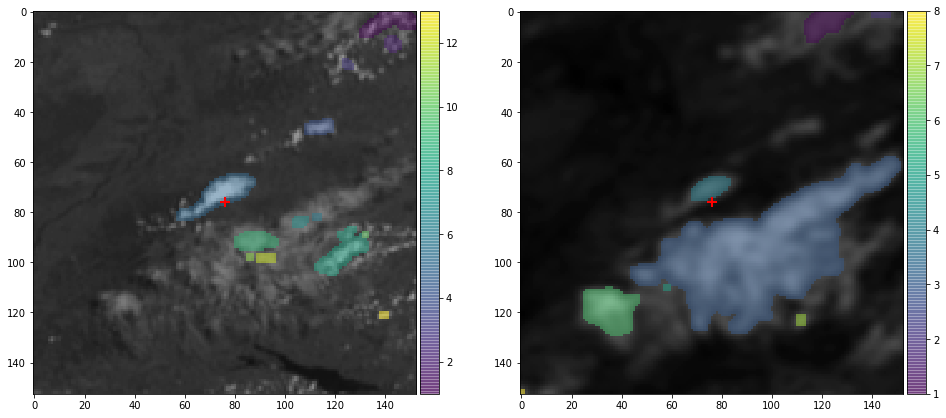

In [174]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax[0].imshow(track_data.hrv.data[6],vmin=0,vmax=1,cmap='gray')
hp = ax[0].imshow(np.ma.masked_less(seg_hrv[6],1),alpha=0.5)
fc.colourbar(hp)
ax[0].plot(ri,ci,'r+',mew=2,markersize=10)
ax[1].imshow(track_data.ir108.data[6],vmin=210,vmax=300,cmap='gray_r')
ip = ax[1].imshow(np.ma.masked_less(seg_ir108[6],1),alpha=0.5)
ax[1].plot(ri,ci,'r+',mew=2,markersize=10)
fc.colourbar(ip)

In [175]:
print seg_hrv[6][ri,ci], seg_ir108[6][ri,ci]

5 0


Im HRV-Kanal liegt der Mittelpunkt in einem Objekt. Im IR-10,8-µm-Kanal ist das nicht der Fall. Aber wir sehen und mal an, welcher Track gewählt wird.

In [176]:
seg_ir108[6][70,75]

4

Das passende Objekt sollte das mit der Nummer 4 sein.

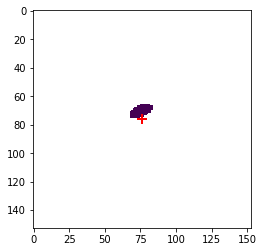

In [181]:
plt.imshow(np.ma.masked_not_equal(seg_ir108[6],4))
plt.plot(ri,ci,'r+',mew=2,markersize=10)

In [209]:
main_track_hrv = ot.get_track_from_labeled_field(seg_hrv)
main_track_ir108 = ot.get_track_from_labeled_field(seg_ir108)

In [210]:
main_track_ir108

['0_0005',
 '1_0004',
 '2_0005',
 '3_0006',
 '4_0006',
 '5_0005',
 '6_0004',
 '7_0005',
 '8_0005',
 '9_0005',
 '10_0002',
 '11_0002',
 '12_0002']

Gut, das passt.